In [48]:
#Step 1: Load and Clean Monthly & Annual Data
import pandas as pd

# Monthly Steel Imports
df_monthly = pd.read_csv("Table 12-10-0121-01.csv", skiprows=10, header=1)
monthly_imports_raw = df_monthly.iloc[0, 3:]
monthly_imports = monthly_imports_raw.T.reset_index()
monthly_imports.columns = ['Month', 'Import_Value_MillionCAD']
monthly_imports['Month'] = pd.date_range(start='2016-01-01', periods=len(monthly_imports), freq='MS')
monthly_imports['Import_Value_MillionCAD'] = monthly_imports['Import_Value_MillionCAD'].astype(str).str.replace(",", "").astype(float)

# Annual Steel Imports
df_annual = pd.read_csv("Table 12-10-0172-01.csv", skiprows=9)
df_annual['Trade'] = df_annual['Trade'].ffill()
df_annual.rename(columns={"North American Product Classification System (NAPCS) 2 3 4": "Product"}, inplace=True)

steel_products = [
    "Unwrought iron, steel and ferro-alloys",
    "Basic and semi-finished iron or steel products",
    "Fabricated metal products"
]

df_steel_annual = df_annual[(df_annual['Trade'] == 'Import') & (df_annual['Product'].isin(steel_products))].copy()
for year in ['2016', '2017', '2018', '2019', '2020']:
    df_steel_annual[year] = df_steel_annual[year].astype(str).str.replace(",", "").astype(float)


In [49]:
#Step 2: Feature Engineering & Labeling
monthly_imports['Year'] = monthly_imports['Month'].dt.year
monthly_imports['TariffPeriod'] = (monthly_imports['Month'] >= '2018-03-01').astype(int)
monthly_imports['YoY_Change'] = monthly_imports['Import_Value_MillionCAD'].pct_change(periods=12)
monthly_imports['MoM_Change'] = monthly_imports['Import_Value_MillionCAD'].pct_change()
monthly_imports['StressFlag'] = (monthly_imports['MoM_Change'] < -0.1).astype(int)


In [50]:
# Step 3: Logistic Regression & Random Forest (PD Models)
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score

features = ['TariffPeriod', 'YoY_Change', 'MoM_Change']
X = monthly_imports[features].fillna(0)
y = monthly_imports['StressFlag']

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.2)

logit = LogisticRegression().fit(X_train, y_train)
rf = RandomForestClassifier(random_state=42).fit(X_train, y_train)

print("Logistic AUC:", roc_auc_score(y_test, logit.predict(X_test)))
print("Random Forest AUC:", roc_auc_score(y_test, rf.predict(X_test)))


Logistic AUC: 0.5
Random Forest AUC: 1.0


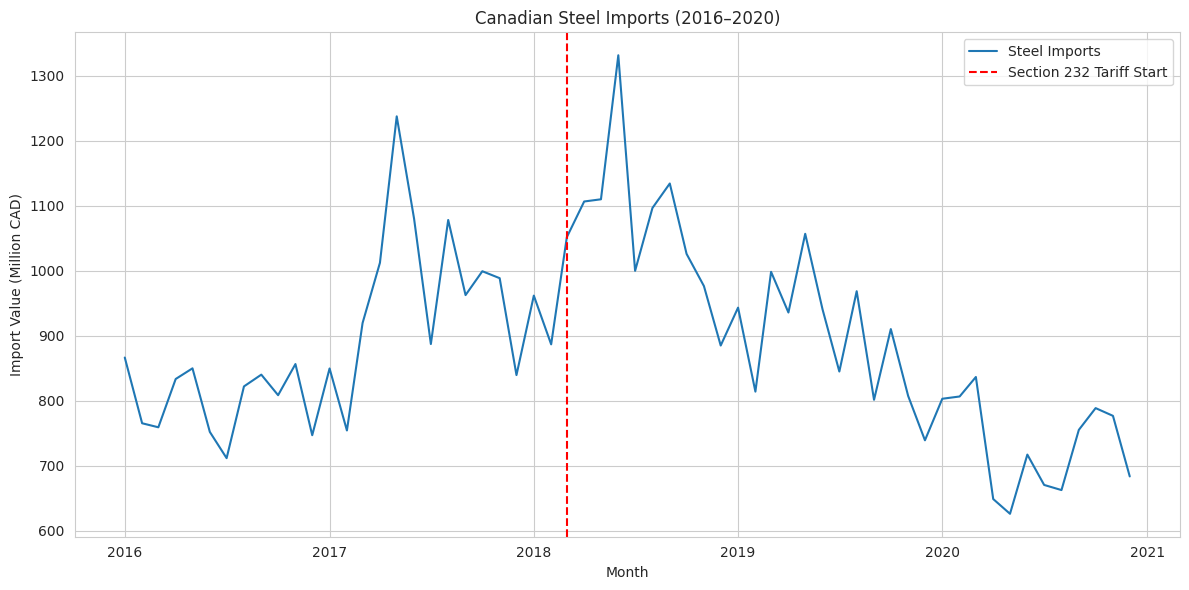

In [51]:
#Step 4: Visualization
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(monthly_imports['Month'], monthly_imports['Import_Value_MillionCAD'], label='Steel Imports')
plt.axvline(pd.to_datetime('2018-03-01'), color='red', linestyle='--', label='Section 232 Tariff Start')
plt.title('Canadian Steel Imports (2016–2020)')
plt.xlabel('Month')
plt.ylabel('Import Value (Million CAD)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("steel_import_trends.png", dpi=300)


In [52]:
#Step 5: Difference-in-Differences (DiD) Model
import statsmodels.formula.api as smf

monthly_imports['Post2018'] = (monthly_imports['Month'] >= '2018-03-01').astype(int)
did_model = smf.ols('Import_Value_MillionCAD ~ TariffPeriod * Post2018', data=monthly_imports).fit()
print(did_model.summary())


                               OLS Regression Results                              
Dep. Variable:     Import_Value_MillionCAD   R-squared:                       0.000
Model:                                 OLS   Adj. R-squared:                 -0.017
Method:                      Least Squares   F-statistic:                  0.004187
Date:                     Fri, 08 Aug 2025   Prob (F-statistic):              0.949
Time:                             23:39:07   Log-Likelihood:                -384.68
No. Observations:                       60   AIC:                             773.4
Df Residuals:                           58   BIC:                             777.5
Df Model:                                1                                         
Covariance Type:                 nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------

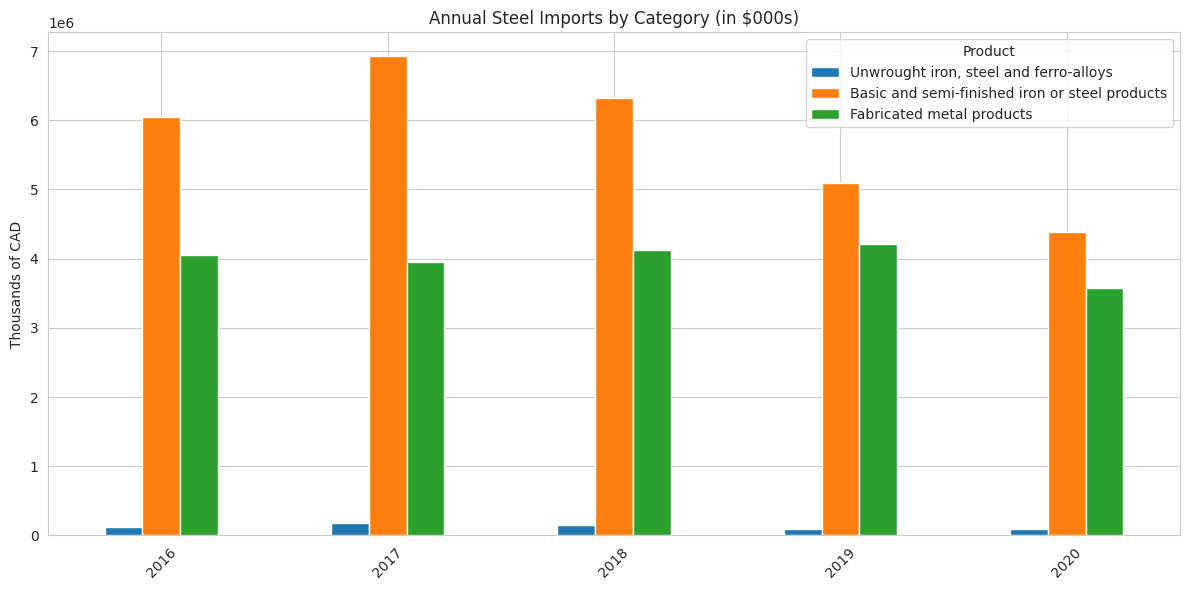

In [53]:
#Step 6: Annual Import Summary
df_plot = df_steel_annual.set_index('Product').T.iloc[1:].astype(float)
df_plot.plot(kind='bar', figsize=(12,6), title='Annual Steel Imports by Category (in $000s)')
plt.ylabel('Thousands of CAD')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("annual_steel_imports.png", dpi=300)


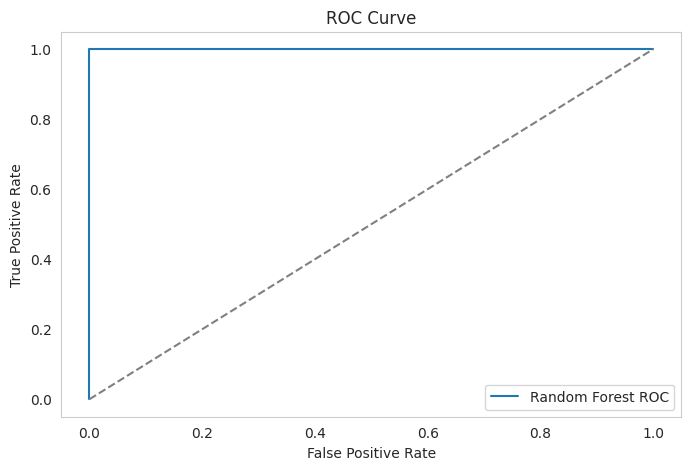

AUC: 1.0
[[10  0]
 [ 0  2]]


In [54]:
#Step 7: ROC Curve, Backtesting & Evaluation
from sklearn.metrics import roc_curve

fpr, tpr, _ = roc_curve(y_test, rf.predict_proba(X_test)[:,1])
plt.figure(figsize=(8, 5))
plt.plot(fpr, tpr, label='Random Forest ROC')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid()
plt.show()
from sklearn.metrics import roc_auc_score
auc = roc_auc_score(y_test, rf.predict_proba(X_test)[:,1])
print("AUC:", auc)
from sklearn.metrics import confusion_matrix
y_pred = rf.predict(X_test)
print(confusion_matrix(y_test, y_pred))



In [55]:
print(df.columns.tolist())


['Month', 'Import_Value_MillionCAD', 'TariffPeriod', 'MoM_Change', 'YoY_Change', 'Log_Import', 'StressFlag', 'PD_rf', 'Expected_Loss_MillionCAD']


In [56]:
#Define Assumptions & Compute Expected Loss (EL = PD × LGD × EAD)
# Step 1: Predict Probability of Default (PD)
predicted_pd = rf.predict_proba(X_test)[:, 1]  # from Random Forest model

# Step 2: Define placeholder values for LGD and EAD
# You can refine these with actual data later
assumed_lgd = 0.45  # 45% loss given default (industry typical for unsecured)
assumed_ead = 10e6  # $10 million exposure at default (arbitrary example)

# Step 3: Compute Expected Loss (EL)
expected_loss = predicted_pd * assumed_lgd * assumed_ead

# Step 4: Add to DataFrame for review
results_df = X_test.copy()
results_df['PD'] = predicted_pd
results_df['Expected_Loss'] = expected_loss

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Review top risk months
print(results_df.sort_values(by='Expected_Loss', ascending=False).head(10))



    TariffPeriod  YoY_Change  MoM_Change    PD  Expected_Loss
51             1   -0.306755   -0.224534  1.00      4500000.0
59             1   -0.075237   -0.120010  0.89      4005000.0
52             1   -0.407684   -0.034998  0.44      1980000.0
55             1   -0.315985   -0.011786  0.44      1980000.0
53             1   -0.237558    0.145550  0.44      1980000.0
54             1   -0.206558   -0.065132  0.34      1530000.0
50             1   -0.162092    0.037202  0.13       585000.0
48             1   -0.148659    0.086468  0.09       405000.0
49             1   -0.009215    0.004359  0.01        45000.0
56             1   -0.057781    0.139795  0.00            0.0


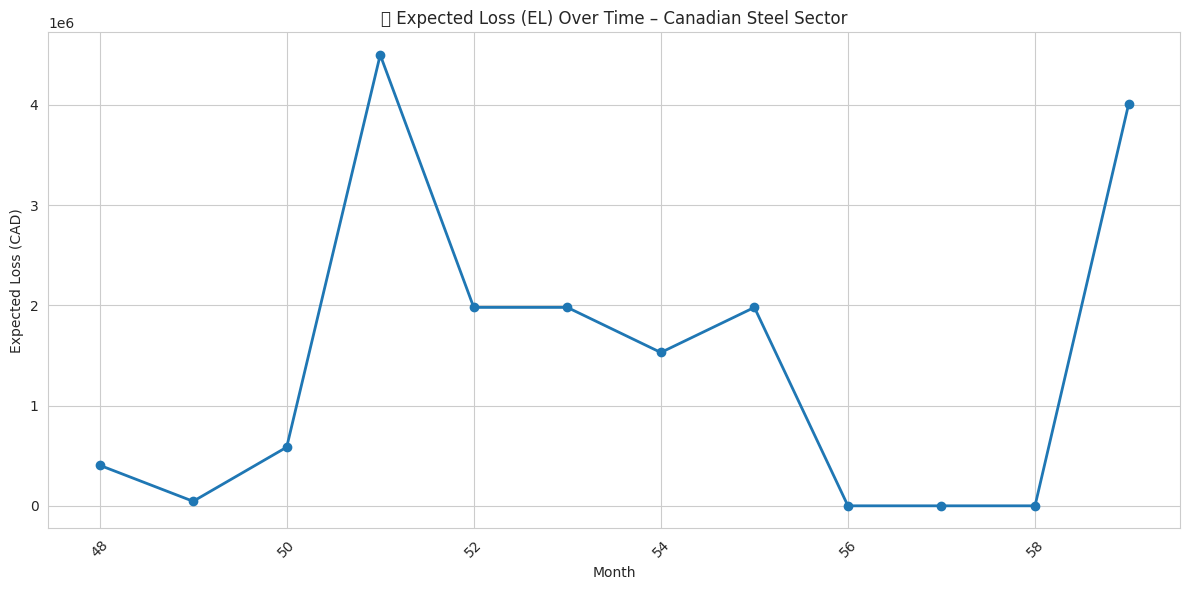

In [57]:
#Plot Expected Loss Over Time
import matplotlib.pyplot as plt

# Step 1: Add a 'Month' index if not already present
# If you already have dates in your dataset, use: results_df['Month'] = pd.to_datetime(...)
results_df = results_df.copy()
results_df['Month'] = results_df.index  # Or use your actual month column

# Step 2: Group by Month to aggregate EL
el_by_month = results_df.groupby('Month')['Expected_Loss'].sum().reset_index()

# Step 3: Plot
plt.figure(figsize=(12,6))
plt.plot(el_by_month['Month'], el_by_month['Expected_Loss'], marker='o', linewidth=2)
plt.title('📉 Expected Loss (EL) Over Time – Canadian Steel Sector')
plt.xlabel('Month')
plt.ylabel('Expected Loss (CAD)')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [60]:
#Step 1 — Imports, config, folders
# Step 1 — Imports, config, folders
import os, json, warnings, sys, logging
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    roc_auc_score, brier_score_loss, confusion_matrix,
    precision_recall_fscore_support, roc_curve, precision_recall_curve
)
from sklearn.calibration import CalibratedClassifierCV
import joblib

import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import grangercausalitytests, adfuller

try:
    import xgboost as xgb
    HAS_XGB = True
except Exception:
    HAS_XGB = False

# -------- Config --------
DATA_MERGED = "Merged_Import___Credit_Risk_Data.csv"  # preferred if available
STATSCAN_MONTHLY = "Table 12-10-0121-01.csv"          # fallback
OUT_DIR = "artifacts_step_by_step"
os.makedirs(OUT_DIR, exist_ok=True)

TARIFF_START = "2018-03-01"
STRESS_DROP = -0.10
LGD = 0.45
EAD = 10_000_000.0
RAND = 42
TS_SPLITS = 3

logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s | %(levelname)s | %(message)s",
    handlers=[logging.StreamHandler(sys.stdout)]
)



In [61]:
#Step 2 — Load data (prefer merged; otherwise parse StatsCan monthly)
def _is_number_like(x) -> bool:
    try:
        float(str(x).replace(",", ""))
        return True
    except Exception:
        return False

def parse_statcan_monthly(filepath: str, start_date="2016-01-01") -> pd.DataFrame:
    """Return df with columns: Month (datetime), Import_Value_MillionCAD (float)."""
    df = pd.read_csv(filepath)
    # Long format?
    month_cols = [c for c in df.columns if c.lower() in ("month", "date")]
    if month_cols:
        mcol = month_cols[0]
        vcol = [c for c in df.columns if c != mcol][-1]
        out = (df[[mcol, vcol]]
               .rename(columns={mcol:"Month", vcol:"Import_Value_MillionCAD"})
               .dropna())
        out["Month"] = pd.to_datetime(out["Month"])
        out["Import_Value_MillionCAD"] = pd.to_numeric(
            out["Import_Value_MillionCAD"].astype(str).str.replace(",", ""), errors="coerce"
        )
        return out.dropna().reset_index(drop=True)
    # Wide format: first row numeric-like cells are the values
    r = df.iloc[0]
    vals = r[r.apply(_is_number_like)].values.astype(float)
    months = pd.date_range(start=start_date, periods=len(vals), freq="MS")
    return pd.DataFrame({"Month": months, "Import_Value_MillionCAD": vals})

def load_best() -> pd.DataFrame:
    if os.path.exists(DATA_MERGED):
        d = pd.read_csv(DATA_MERGED)
        # Try to standardize column names from your merged file
        rename_map = {
            "ImportValue":"Import_Value_MillionCAD",
            "import_value":"Import_Value_MillionCAD",
            "month":"Month"
        }
        d = d.rename(columns=rename_map)
        if "Month" not in d or "Import_Value_MillionCAD" not in d:
            raise ValueError("Merged file must include 'Month' and 'Import_Value_MillionCAD' (or mappable names).")
        d["Month"] = pd.to_datetime(d["Month"])
        d = d.sort_values("Month").reset_index(drop=True)
        # Ignore any existing PD/EL columns (we recompute)
        for c in ["PD","PD_logistic","EL","Expected_Loss_MillionCAD"]:
            if c in d: d = d.drop(columns=c)
        return d[["Month","Import_Value_MillionCAD"]]
    elif os.path.exists(STATSCAN_MONTHLY):
        return parse_statcan_monthly(STATSCAN_MONTHLY, start_date="2016-01-01")
    else:
        raise FileNotFoundError("No input CSVs found. Put merged or StatsCan monthly CSV beside the notebook.")

df_raw = load_best()
print(df_raw.head())
print(df_raw.tail())
print(df_raw.dtypes)


       Month  Import_Value_MillionCAD
0 2016-01-01                    866.3
1 2016-02-01                    765.2
2 2016-03-01                    759.0
3 2016-04-01                    833.3
4 2016-05-01                    849.7
        Month  Import_Value_MillionCAD
43 2020-08-01                    662.4
44 2020-09-01                    755.0
45 2020-10-01                    788.5
46 2020-11-01                    776.6
47 2020-12-01                    683.4
Month                      datetime64[ns]
Import_Value_MillionCAD           float64
dtype: object


In [62]:
#Step 3 — Feature engineering
def make_features(df: pd.DataFrame, tariff_start=TARIFF_START, stress_drop=STRESS_DROP) -> pd.DataFrame:
    out = df.copy()
    out["Month"] = pd.to_datetime(out["Month"])
    out = out.sort_values("Month").reset_index(drop=True)
    out["Import_Value_MillionCAD"] = pd.to_numeric(out["Import_Value_MillionCAD"], errors="coerce")

    out["TariffPeriod"] = (out["Month"] >= pd.to_datetime(tariff_start)).astype(int)
    out["MoM_Change"] = out["Import_Value_MillionCAD"].pct_change().fillna(0.0)
    out["YoY_Change"] = out["Import_Value_MillionCAD"].pct_change(periods=12).fillna(0.0)
    out["Log_Import"] = np.log(out["Import_Value_MillionCAD"].replace(0, np.nan))
    out["Log_Import"] = out["Log_Import"].fillna(out["Log_Import"].median())

    # Label: sector stress when sharp drop
    out["StressFlag"] = (out["MoM_Change"] < stress_drop).astype(int)
    return out

df = make_features(df_raw)
df.to_csv(os.path.join(OUT_DIR, "prepared_data.csv"), index=False)
df.head(10)


,Month,Import_Value_MillionCAD,TariffPeriod,MoM_Change,YoY_Change,Log_Import,StressFlag
0,2016-01-01,866.3,0,0.000000,0.0,6.764231,0
1,2016-02-01,765.2,0,-0.116703,0.0,6.640137,1
2,2016-03-01,759.0,0,-0.008102,0.0,6.632002,0
3,2016-04-01,833.3,0,0.097892,0.0,6.725394,0
4,2016-05-01,849.7,0,0.019681,0.0,6.744883,0
5,2016-06-01,751.9,0,-0.115099,0.0,6.622603,1
6,2016-07-01,711.5,0,-0.053731,0.0,6.567375,0
7,2016-08-01,821.9,0,0.155165,0.0,6.711619,0
8,2016-09-01,840.0,0,0.022022,0.0,6.733402,0
9,2016-10-01,808.4,0,-0.037619,0.0,6.695057,0


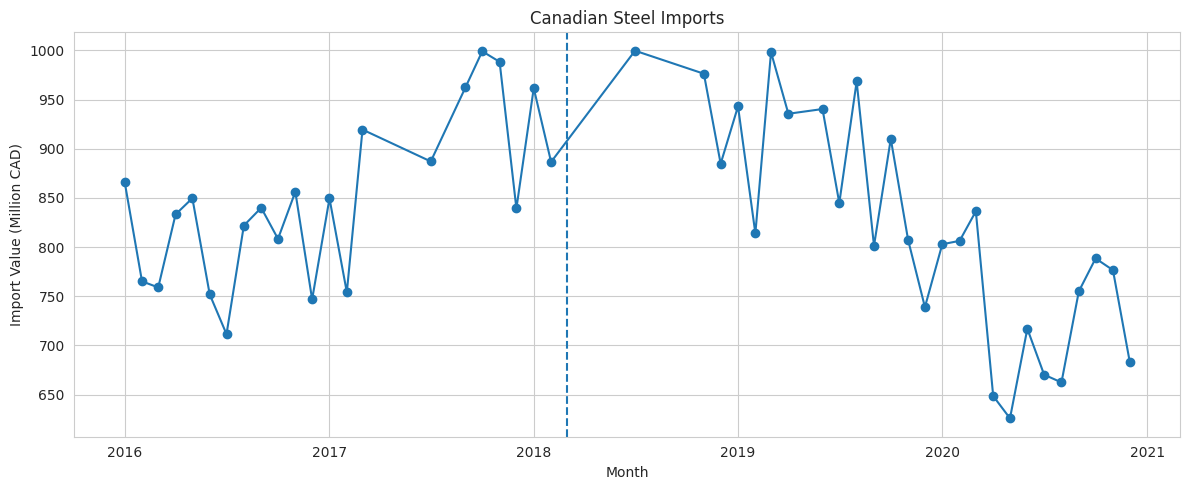

In [63]:
#Step 4 — Plot series (quick sanity)
plt.figure(figsize=(12,5))
plt.plot(df["Month"], df["Import_Value_MillionCAD"], marker="o")
plt.axvline(pd.to_datetime(TARIFF_START), linestyle="--")
plt.title("Canadian Steel Imports")
plt.xlabel("Month"); plt.ylabel("Import Value (Million CAD)")
plt.grid(True); plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, "steel_import_trends.png"), dpi=300)
plt.show()


In [64]:
#Step 5 — Train/test split (time-aware)
FEATURES = ["TariffPeriod", "YoY_Change", "MoM_Change", "Log_Import"]
TARGET = "StressFlag"

X = df[FEATURES].fillna(0.0)
y = df[TARGET].astype(int)

split_idx = int(len(df) * 0.8)  # last ~20% = holdout
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

len(X_train), len(X_test)


(38, 10)

In [65]:
#Step 6 — Train baseline models (Logistic + Random Forest)
# Logistic (scaled)
scaler = StandardScaler().fit(X_train)
log_model = LogisticRegression(max_iter=500, random_state=RAND)
log_model.fit(scaler.transform(X_train), y_train)

# Random Forest (moderate size for small data)
rf_model = RandomForestClassifier(
    n_estimators=300, max_depth=None, min_samples_leaf=2, n_jobs=-1, random_state=RAND
)
rf_model.fit(X_train, y_train)

# Optional XGBoost (light)
if HAS_XGB:
    xgb_model = xgb.XGBClassifier(
        n_estimators=300, max_depth=3, learning_rate=0.05, subsample=0.9,
        colsample_bytree=0.9, eval_metric="logloss", n_jobs=-1, random_state=RAND
    )
    xgb_model.fit(X_train, y_train)
else:
    xgb_model = None


In [66]:
#Step 7 — Evaluate (AUC, Brier, confusion, PR/F1) and save metrics
def eval_model(model, X_in, y_true, scaler=None):
    X_eval = scaler.transform(X_in) if scaler is not None else X_in
    prob = model.predict_proba(X_eval)[:, 1]
    pred = (prob >= 0.5).astype(int)
    auc = roc_auc_score(y_true, prob)
    brier = brier_score_loss(y_true, prob)
    cm = confusion_matrix(y_true, pred).tolist()
    pr, rc, f1, _ = precision_recall_fscore_support(y_true, pred, average="binary", zero_division=0)
    return {"auc": float(auc), "brier": float(brier), "cm": cm,
            "precision": float(pr), "recall": float(rc), "f1": float(f1)}

metrics = {
    "logistic": eval_model(log_model, X_test, y_test, scaler=scaler),
    "rf":       eval_model(rf_model,  X_test, y_test),
}
if xgb_model is not None:
    metrics["xgb"] = eval_model(xgb_model, X_test, y_test)

with open(os.path.join(OUT_DIR, "metrics.json"), "w") as f:
    json.dump(metrics, f, indent=2)

print(json.dumps(metrics, indent=2))


{
  "logistic": {
    "auc": 1.0,
    "brier": 0.12902568857362656,
    "cm": [
      [
        5,
        3
      ],
      [
        0,
        2
      ]
    ],
    "precision": 0.4,
    "recall": 1.0,
    "f1": 0.5714285714285714
  },
  "rf": {
    "auc": 1.0,
    "brier": 0.019941364578259284,
    "cm": [
      [
        8,
        0
      ],
      [
        0,
        2
      ]
    ],
    "precision": 1.0,
    "recall": 1.0,
    "f1": 1.0
  },
  "xgb": {
    "auc": 1.0,
    "brier": 0.0045835856062932945,
    "cm": [
      [
        8,
        0
      ],
      [
        0,
        2
      ]
    ],
    "precision": 1.0,
    "recall": 1.0,
    "f1": 1.0
  }
}


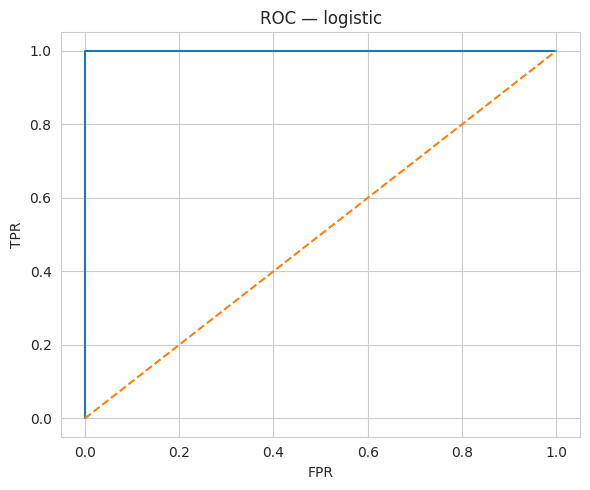

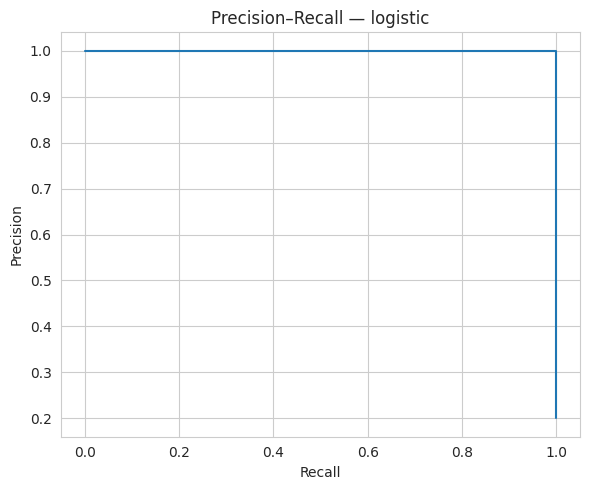

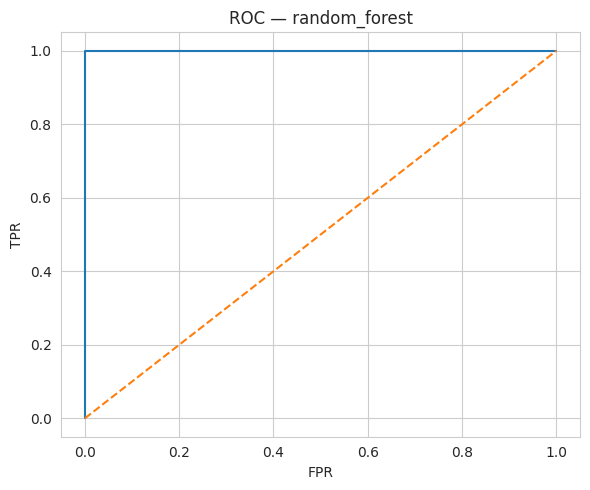

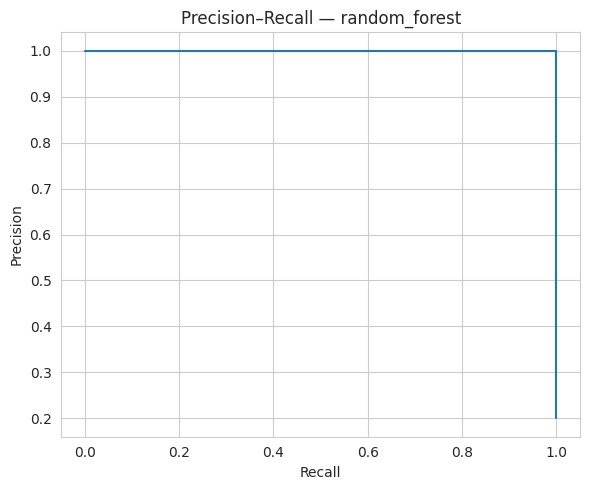

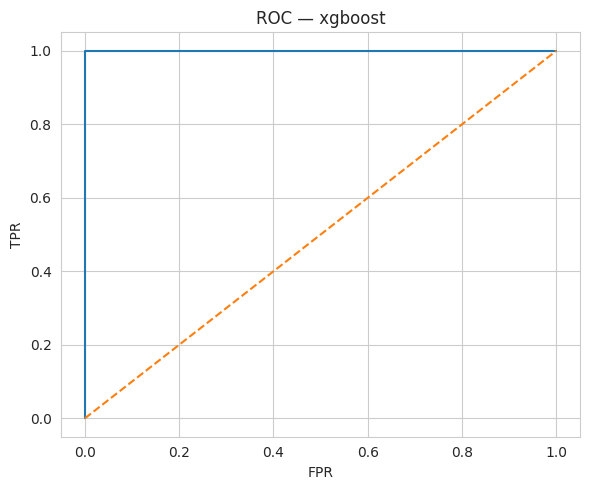

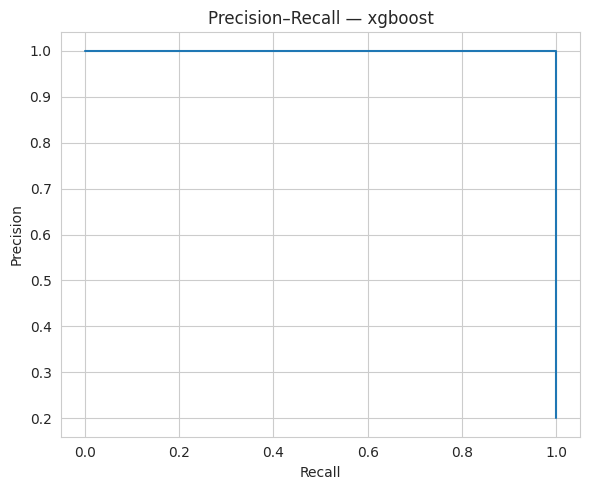

In [67]:
#Step 8 — ROC & PR curves (saved as PNGs)
def save_curves(y_true, y_prob, label):
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    prec, rec, _ = precision_recall_curve(y_true, y_prob)

    plt.figure(figsize=(6,5))
    plt.plot(fpr, tpr); plt.plot([0,1],[0,1],'--')
    plt.title(f"ROC — {label}")
    plt.xlabel("FPR"); plt.ylabel("TPR")
    plt.tight_layout(); plt.savefig(os.path.join(OUT_DIR, f"roc_{label}.png"), dpi=300)
    plt.show()

    plt.figure(figsize=(6,5))
    plt.plot(rec, prec)
    plt.title(f"Precision–Recall — {label}")
    plt.xlabel("Recall"); plt.ylabel("Precision")
    plt.tight_layout(); plt.savefig(os.path.join(OUT_DIR, f"pr_{label}.png"), dpi=300)
    plt.show()

# Save curves for each trained model
prob_log = log_model.predict_proba(scaler.transform(X_test))[:,1]
save_curves(y_test, prob_log, "logistic")

prob_rf = rf_model.predict_proba(X_test)[:,1]
save_curves(y_test, prob_rf, "random_forest")

if xgb_model is not None:
    prob_xgb = xgb_model.predict_proba(X_test)[:,1]
    save_curves(y_test, prob_xgb, "xgboost")


In [68]:
#Step 9 — Full-sample PDs (choose best model) & Expected Loss time-series
# Pick a model to produce PDs (use RF by default; swap to logistic if preferred)
best_for_pd = rf_model  # or log_model with scaler

if best_for_pd is rf_model:
    pd_hat = best_for_pd.predict_proba(X)[:,1]
    label_pd = "PD_rf"
else:
    pd_hat = best_for_pd.predict_proba(scaler.transform(X))[:,1]
    label_pd = "PD_logistic"

df[label_pd] = pd_hat
df["Expected_Loss_MillionCAD"] = df[label_pd] * LGD * EAD / 1e6

df_out = df.copy()
df_out.to_csv(os.path.join(OUT_DIR, "monthly_with_PD_EL.csv"), index=False)
df_out[["Month","Import_Value_MillionCAD",label_pd,"Expected_Loss_MillionCAD"]].head(12)


,Month,Import_Value_MillionCAD,PD_rf,Expected_Loss_MillionCAD
0,2016-01-01,866.3,0.002407,0.010833
1,2016-02-01,765.2,0.928407,4.177833
2,2016-03-01,759.0,0.075352,0.339083
3,2016-04-01,833.3,0.030759,0.138417
4,2016-05-01,849.7,0.006574,0.029583
5,2016-06-01,751.9,0.944519,4.250333
6,2016-07-01,711.5,0.096185,0.432833
7,2016-08-01,821.9,0.025481,0.114667
8,2016-09-01,840.0,0.029815,0.134167
9,2016-10-01,808.4,0.032296,0.145333


In [69]:
#Step 9 — Full-sample PDs (choose best model) & Expected Loss time-series
# Pick a model to produce PDs (use RF by default; swap to logistic if preferred)
best_for_pd = rf_model  # or log_model with scaler

if best_for_pd is rf_model:
    pd_hat = best_for_pd.predict_proba(X)[:,1]
    label_pd = "PD_rf"
else:
    pd_hat = best_for_pd.predict_proba(scaler.transform(X))[:,1]
    label_pd = "PD_logistic"

df[label_pd] = pd_hat
df["Expected_Loss_MillionCAD"] = df[label_pd] * LGD * EAD / 1e6

df_out = df.copy()
df_out.to_csv(os.path.join(OUT_DIR, "monthly_with_PD_EL.csv"), index=False)
df_out[["Month","Import_Value_MillionCAD",label_pd,"Expected_Loss_MillionCAD"]].head(12)


,Month,Import_Value_MillionCAD,PD_rf,Expected_Loss_MillionCAD
0,2016-01-01,866.3,0.002407,0.010833
1,2016-02-01,765.2,0.928407,4.177833
2,2016-03-01,759.0,0.075352,0.339083
3,2016-04-01,833.3,0.030759,0.138417
4,2016-05-01,849.7,0.006574,0.029583
5,2016-06-01,751.9,0.944519,4.250333
6,2016-07-01,711.5,0.096185,0.432833
7,2016-08-01,821.9,0.025481,0.114667
8,2016-09-01,840.0,0.029815,0.134167
9,2016-10-01,808.4,0.032296,0.145333


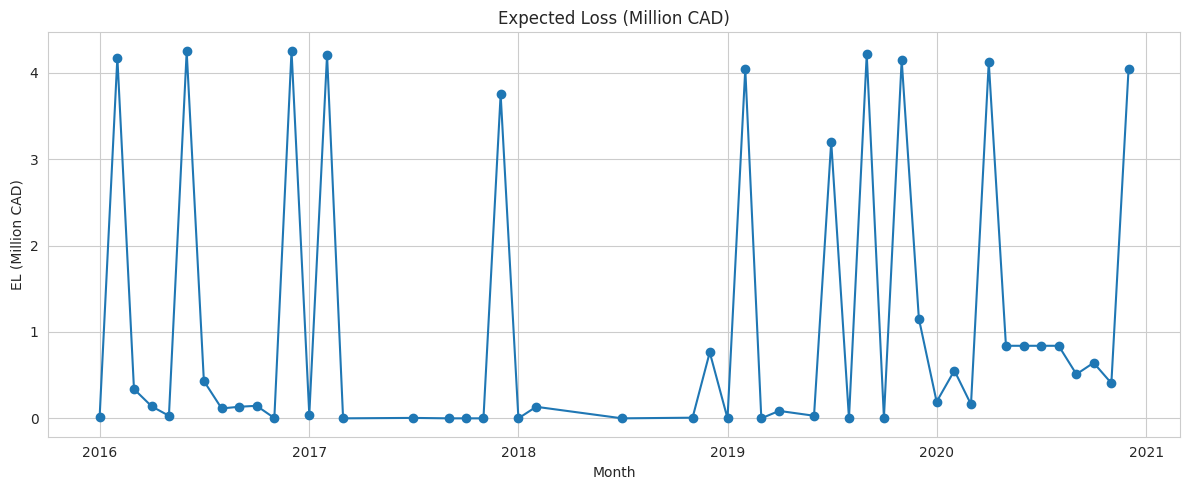

In [70]:
#Step 10 — Plot Expected Loss (EL)
plt.figure(figsize=(12,5))
plt.plot(df["Month"], df["Expected_Loss_MillionCAD"], marker="o")
plt.title("Expected Loss (Million CAD)")
plt.xlabel("Month"); plt.ylabel("EL (Million CAD)")
plt.grid(True); plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, "el_timeseries.png"), dpi=300)
plt.show()


In [71]:
#Step 11 — Interrupted Time Series (level & slope change at Mar-2018)
d = df.copy()
d["t"] = np.arange(len(d)) + 1
d["Post"] = (d["Month"] >= pd.to_datetime(TARIFF_START)).astype(int)
d["Post_t"] = d["Post"] * d["t"]

its = smf.ols("Import_Value_MillionCAD ~ t + Post + Post_t", data=d).fit(cov_type="HC1")
with open(os.path.join(OUT_DIR, "its_summary.txt"), "w") as f:
    f.write(its.summary().as_text())

its.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                               OLS Regression Results                              
===================================================================================
Dep. Variable:     Import_Value_MillionCAD   R-squared:                       0.574
Model:                                 OLS   Adj. R-squared:                  0.545
Method:                      Least Squares   F-statistic:                     20.19
Date:                     Fri, 08 Aug 2025   Prob (F-statistic):           2.22e-08
Time:                             23:40:40   Log-Likelihood:                -268.46
No. Observations:                       48   AIC:                             544.9
Df Residuals:                           44   BIC:                             552.4
Df Model:                                3                                         
Covariance Type:                       HC1                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    757.4688     27.548     27.497      0.000     703.477     811.461
t              7.8798      2.208      3.569      0.000       3.552      12.207
Post         487.2876     66.384      7.340      0.000     357.177     617.398
Post_t       -19.8272      2.804     -7.071      0.000     -25.323     -14.331
==============================================================================
Omnibus:                        3.571   Durbin-Watson:                   1.835
Prob(Omnibus):                  0.168   Jarque-Bera (JB):                1.973
Skew:                          -0.226   Prob(JB):                        0.373
Kurtosis:                       2.115   Cond. No.                         283.
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC1)
"""

ADF p Import_pct: 1.4286502712125844e-20
ADF p PD_diff: 2.2204428622657152e-07
VAR lag (AIC): 1


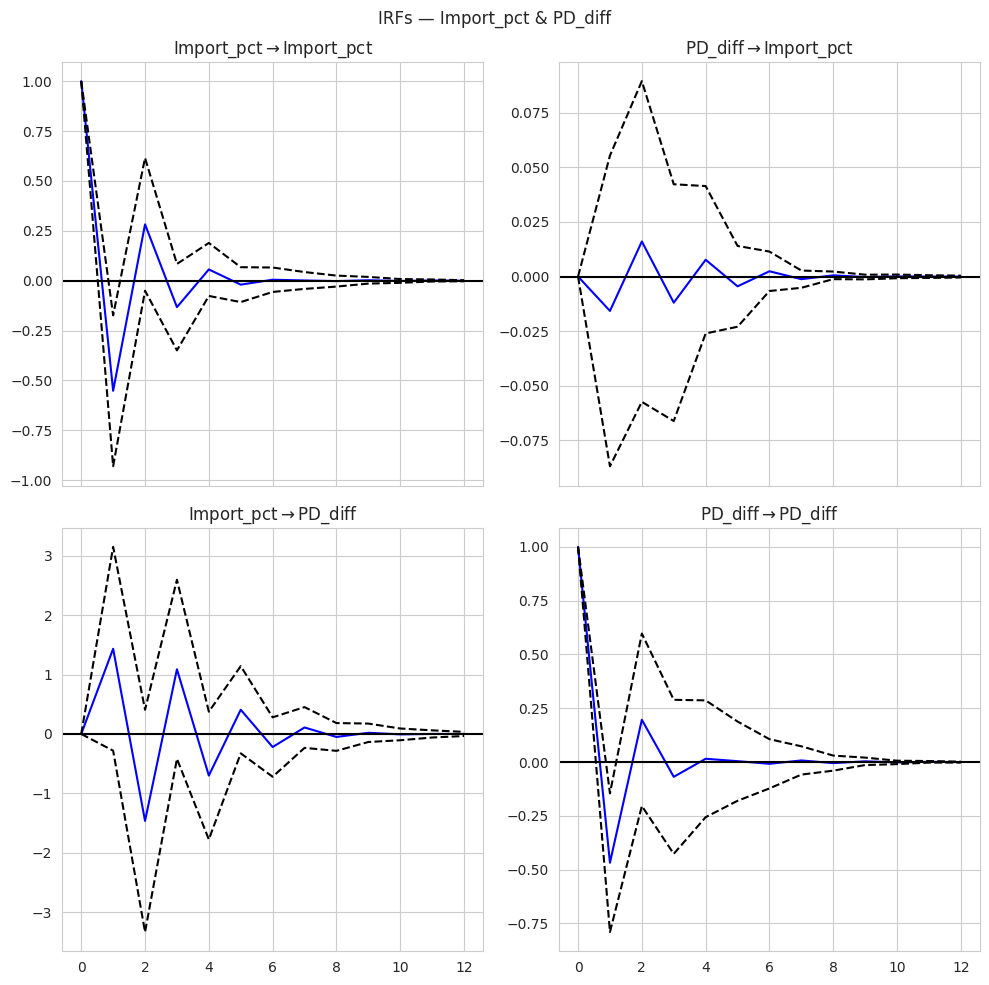


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.6865  , p=0.1083  , df_denom=44, df_num=1
ssr based chi2 test:   chi2=2.8696  , p=0.0903  , df=1
likelihood ratio test: chi2=2.7854  , p=0.0951  , df=1
parameter F test:         F=2.6865  , p=0.1083  , df_denom=44, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1881  , p=0.6666  , df_denom=44, df_num=1
ssr based chi2 test:   chi2=0.2009  , p=0.6540  , df=1
likelihood ratio test: chi2=0.2005  , p=0.6543  , df=1
parameter F test:         F=0.1881  , p=0.6666  , df_denom=44, df_num=1


In [72]:
#Step 12 — VAR + Granger (stationary transforms)
def adf_p(series):
    series = pd.Series(series).dropna()
    if len(series) < 10: return 1.0
    try:
        return adfuller(series, autolag="AIC")[1]
    except Exception:
        return 1.0

ts = df[["Month","Import_Value_MillionCAD",label_pd]].dropna().copy()
ts["Import_pct"] = ts["Import_Value_MillionCAD"].pct_change().fillna(0.0)
ts["PD_diff"] = ts[label_pd].diff().fillna(0.0)
print("ADF p Import_pct:", adf_p(ts["Import_pct"]))
print("ADF p PD_diff:", adf_p(ts["PD_diff"]))

var_df = ts[["Import_pct","PD_diff"]]
model = VAR(var_df)
lag_sel = model.select_order(6)
lag = int(lag_sel.aic or 2)
res = model.fit(lag)
print("VAR lag (AIC):", lag)

irf = res.irf(12)
fig = irf.plot(orth=False)
plt.suptitle("IRFs — Import_pct & PD_diff")
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, "irf_plot.png"), dpi=300)
plt.show()

# Granger: Imports -> PD
g1 = grangercausalitytests(var_df[["PD_diff","Import_pct"]], maxlag=min(4, lag), verbose=True)
# Granger: PD -> Imports
g2 = grangercausalitytests(var_df[["Import_pct","PD_diff"]], maxlag=min(4, lag), verbose=True)


In [73]:
#Step 13 — (optional) Save models + quick resume JSON
joblib.dump(
    {"scaler": scaler, "logistic": log_model, "rf": rf_model, "xgb": xgb_model},
    os.path.join(OUT_DIR, "models.joblib")
)

summary = {
    "features": FEATURES,
    "metrics": json.loads(open(os.path.join(OUT_DIR, "metrics.json")).read()),
    "lgd": LGD, "ead": EAD, "tariff_start": TARIFF_START, "stress_threshold": STRESS_DROP
}
with open(os.path.join(OUT_DIR, "run_summary.json"), "w") as f:
    json.dump(summary, f, indent=2)

print("Saved artifacts in:", OUT_DIR)


Saved artifacts in: artifacts_step_by_step
